# CodeBase

### Imports & Configuration

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import seaborn as sns
from tqdm import tqdm
import joblib
from scipy.interpolate import interp1d
%matplotlib inline
sns.set_theme(style='whitegrid')

In [ ]:
data_path = './EIS_Fitting_Results.csv'

df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()

### Variation of Diffusion Parameters with SoC

In [ ]:
pdf = df[['SoC', 'SoH','Cycle','W1']]
print(pdf.head())
filtered_pdf = pdf[pdf['Cycle'].isin([0, 90, 135])].reset_index(drop=True)
print(filtered_pdf.head())

In [ ]:
for cycle in filtered_pdf['Cycle'].unique():
    fig, ax = plt.subplots(figsize=(10, 8))  # Get both figure and axes
    
    cycle_data = filtered_pdf[filtered_pdf['Cycle'] == cycle]
    
    ax.plot(
        cycle_data['SoC'], 
        cycle_data['W1'], 
        marker='o', linestyle='-', color='b', 
        label='Warburg Diffusion Parameter (σ)',
        linewidth=3, markersize=8
    )
    ax.set_xticklabels([f"{int(t)}%" for t in ax.get_xticks()])
    ax.set_xlabel('SoC Values', fontsize=26, fontweight='bold')
    ax.set_ylabel(r'Warburg Diffusion Parameter $[\Omega \cdot s^{1/2}]$', fontsize=26, fontweight='bold')
    ax.set_title(f'Variation of Diffusion Parameters with SoC (Cycle {cycle})', fontsize=26, pad=20)
    ax.tick_params(axis='both', which='major', labelsize=24)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.grid(False)
    ax.legend(fontsize=18)
    
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    plt.tight_layout()
    plt.show()

In [ ]:
pdf = df[['SoC', 'SoH','Cycle','R1']]
print(pdf.head())
filtered_pdf = pdf[pdf['Cycle'].isin([0, 90, 135])].reset_index(drop=True)
print(filtered_pdf.head())

In [ ]:
for cycle in filtered_pdf['Cycle'].unique():
    fig, ax = plt.subplots(figsize=(10, 8))  # Get both figure and axes
    
    cycle_data = filtered_pdf[filtered_pdf['Cycle'] == cycle]
    
    ax.plot(
        cycle_data['SoC'], 
        cycle_data['R1'], 
        marker='o', linestyle='-', color='b', 
        label='Warburg Diffusion Parameter (σ)',
        linewidth=3, markersize=8
    )
    ax.set_xticklabels([f"{int(t)}%" for t in ax.get_xticks()])
    ax.set_xlabel('SoC Values', fontsize=26, fontweight='bold')
    ax.set_ylabel(r'Charge Transfer Resistance $[\Omega]$', fontsize=26, fontweight='bold')
    ax.set_title(f'Variation of $R_{{{"ct"}}}$ with SoC (Cycle {cycle})', fontsize=26, pad=20)
    ax.tick_params(axis='both', which='major', labelsize=24)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.grid(False)
    ax.legend(fontsize=18)
    
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    plt.tight_layout()
    plt.show()

### Filtering Data


In [ ]:
# Identify EIS fitted parameters (example: R0, R1, W1, Q1, alpha1)
param_cols = [col for col in df.columns if col not in ['Cycle', 'SoH', 'SoC']]
meta_cols = ['Cycle', 'SoH', 'SoC']

# Drop any rows with missing values
df = df.dropna(subset=param_cols)

# Ensure numeric SoH (remove % if any string remains)
df['SoH'] = df['SoH'].astype(str).str.replace('%', '').astype(float) / 100

# Display available parameters
print("Fitted Parameters:", param_cols)

In [3]:
# fixed_freqs = np.logspace(4, -1, num=100)

def load_eis_and_interpolate(x=0, y=0,num_points=100, eis_path=None):
    # Build path
    if eis_path is None:
        eis_path = f"./LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/EIS_{x}/{y}_EIS.csv"
    if not os.path.exists(eis_path):
        return None
    print(f"Loading EIS data from: {eis_path}")
    # eis_df = pd.read_csv(eis_path, header=None, names=['Freq', 'Re', 'Im'], delimiter='\t')
    eis_df = pd.read_csv(eis_path, header=None, names=['Freq', 'Re', 'Im'])
    
    try:
        f = eis_df['Freq'].values
        Z_re = eis_df['Re'].values
        Z_im = eis_df['Im'].values
        print(f"Processing file: {eis_path}")
        # if np.min(f) > np.min(fixed_freqs) or np.max(f) < np.max(fixed_freqs):
        #     print(f"[Warning] Frequency range insufficient for file: {eis_path}")
        #     return None
        logf = np.log10(f)
        min_logf = np.max([np.log10(np.min(f)), -1])  # Clamp lower bound to 0.1 Hz
        max_logf = np.min([np.log10(np.max(f)), 5])   # Clamp upper bound to 100,000 Hz

        if min_logf >= max_logf:
            print(f"[Warning] Skipping file due to invalid frequency bounds: {eis_path}")
            return None

        fixed_log_freqs = np.linspace(max_logf, min_logf, num=num_points)
        fixed_freqs = 10**fixed_log_freqs
        
        # Interpolate real and imaginary parts
        interp_re = interp1d(logf, Z_re, kind='cubic', fill_value='extrapolate', bounds_error=False)
        interp_im = interp1d(logf, Z_im, kind='cubic', fill_value='extrapolate', bounds_error=False)

        Z_re_interp = interp_re(fixed_log_freqs)
        Z_im_interp = interp_im(fixed_log_freqs)


        return np.concatenate([Z_re_interp, Z_im_interp])
    except Exception as e:
        print("Can't interpolate: " + str(e))
        return None

### Construct Feature Matrix & Labels

In [ ]:
def get_y_from_soc_cycle(soc, cycle, soc_val_dir="./soc_val"):
    """
    Extract the y value from the soc_val folder for a given SoC and cycle number.
    """
    soc_file = f"EISFiles_SoC{soc}.csv"
    soc_path = os.path.join(soc_val_dir, soc_file)
    if not os.path.exists(soc_path):
        raise FileNotFoundError(f"No file for SoC {soc} at {soc_path}")
    df = pd.read_csv(soc_path, header=None, names=['cycle', 'y'], delimiter='\t')
    row = df[df['cycle'] == cycle]
    if row.empty:
        raise ValueError(f"Cycle {cycle} not found in {soc_path}")
    return int(row.iloc[0]['y'])

In [8]:
X = []
y = []

# for _, row in tqdm(df.iterrows(), total=len(df)):
#     x_val = int(row['Cycle'])
#     y_val = get_y_from_soc_cycle(int(row['SoC']),x_val)  # or use index from filelist if y is a filename
#     print(f"Processing Cycle: {x_val}, SoC: {y_val}")
#     spectrum = load_eis_and_interpolate(x_val, y_val)
#     if spectrum is not None:
#         X.append(spectrum)
#         y.append([row[col] for col in param_cols])
spectrum = load_eis_and_interpolate(eis_path='./EISFitting_Local_rGO_1.csv')
X.append(spectrum)
spectrum = load_eis_and_interpolate(eis_path='./EISFitting_Local_rGO_2.csv')
X.append(spectrum)
spectrum = load_eis_and_interpolate(eis_path='./EISFitting_Local_rGO_3.csv')
X.append(spectrum)
y.append([5.786,30.49e-6,0.8668,10.91,14.3,0.9639e-3,20.88])
y.append([11.48,59.2e-6,0.8053,9.594,16.78,1.165e-3,17.16])
y.append([3.223,0.1459e-3,0.4013,41.19,6.893,0.95e-3,2.603])
#    R1 = 3.223 Ohm
#    Q2 = 0.145 9e-3 F.s^(a - 1)
#    a2 = 0.401 3 
#    R2 = 41.19 Ohm
#    Rd3 = 6.893 Ohm
#    td3 = 0.95e-3 s
#    s1 = 2.603 Ohm.s^-1/2
#    R1 = 11.48 Ohm
#    Q2 = 59.2e-6 F.s^(a - 1)
#    a2 = 0.805 3 
#    R2 = 9.594 Ohm
#    Rd3 = 16.78 Ohm
#    td3 = 1.165e-3 s
#    s1 = 17.16 Ohm.s^-1/2
#    R1 = 5.786 Ohm
#    Q2 = 30.49e-6 F.s^(a - 1)
#    a2 = 0.866 8 
#    R2 = 10.91 Ohm
#    Rd3 = 14.3 Ohm
#    td3 = 0.963 9e-3 s
#    s1 = 20.88 Ohm.s^-1/2
#    R1 = 3.502 Ohm
#    Q2 = 14.74e-6 F.s^(a - 1)
#    a2 = 0.9029 
#    R2 = 249.5 Ohm
#    Rd3 = 107.8 Ohm
#    td3 = 2.583e-3 s
#    s1 = 329.5 Ohm.s^-1/2
#    R1 = 6.08 Ohm
#    Q2 = 24.38e-6 F.s^(a - 1)
#    a2 = 0.869 6 
#    R2 = 30 Ohm
#    Rd3 = 57.43 Ohm
#    td3 = 0.928 6e-3 s
#    s1 = 35.67 Ohm.s^-1/2
#    R1 = 11.84 Ohm
#    Q2 = 0.218 9e-3 F.s^(a - 1)
#    a2 = 0.426 9 
#    R2 = 39.19 Ohm
#    Rd3 = 14.71 Ohm
#    td3 = 1.31e-3 s
#    s1 = 0.352 1 Ohm.s^-1/2
X = np.array(X)
y = np.array(y)

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

Loading EIS data from: ./EISFitting_Local_rGO_1.csv
Processing file: ./EISFitting_Local_rGO_1.csv
Loading EIS data from: ./EISFitting_Local_rGO_2.csv
Processing file: ./EISFitting_Local_rGO_2.csv
Loading EIS data from: ./EISFitting_Local_rGO_3.csv
Processing file: ./EISFitting_Local_rGO_3.csv
Final X shape: (3, 200)
Final y shape: (3, 7)


### Training ML Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)
param_cols = ["R1","CPE1_T","CPE1_P","R2","Wo3_R","Wo3_T","W1_R"]
# Evaluate
for i, name in enumerate(param_cols):
    # print(f"{name} → R²: {r2_score(y_test[:, i], y_pred[:, i]):.4f}, RMSE: {root_mean_squared_error(y_test[:, i], y_pred[:, i]):.4f}")
    print(f"{name} → RMSE: {root_mean_squared_error(y_test[:, i], y_pred[:, i]):.4f}")

R1 → RMSE: 3.6710
CPE1_T → RMSE: 0.0000
CPE1_P → RMSE: 0.1605
R2 → RMSE: 6.4250
Wo3_R → RMSE: 0.0577
Wo3_T → RMSE: 0.0001
W1_R → RMSE: 7.2865


In [ ]:
new_y_pred = model.predict()

### Plotting & Saving Model

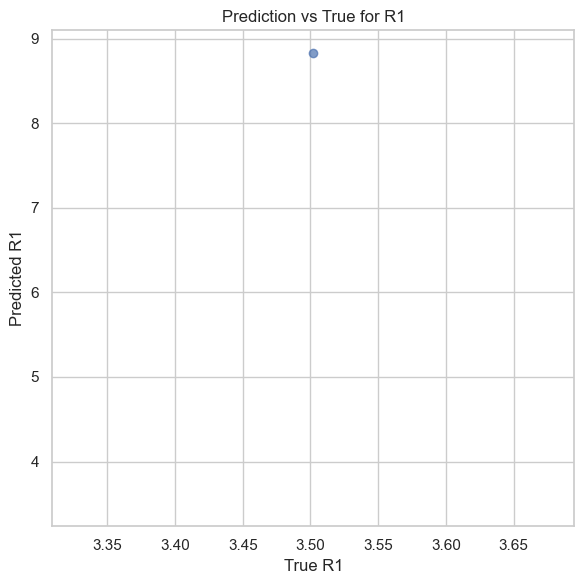

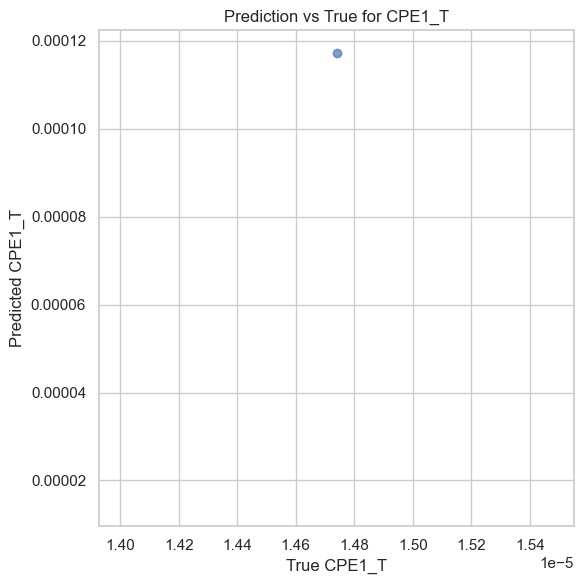

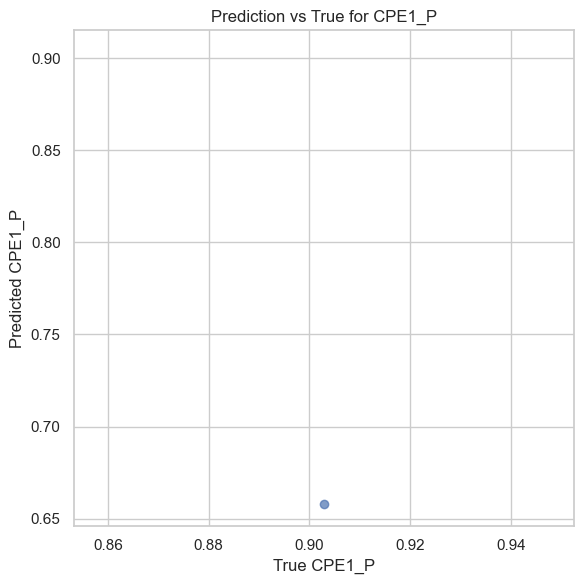

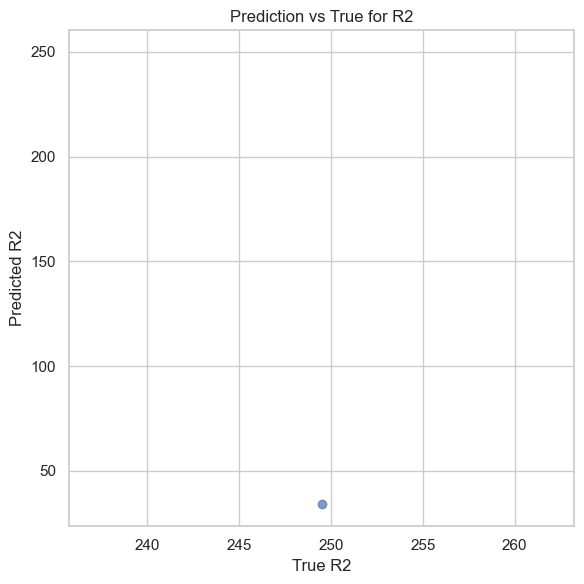

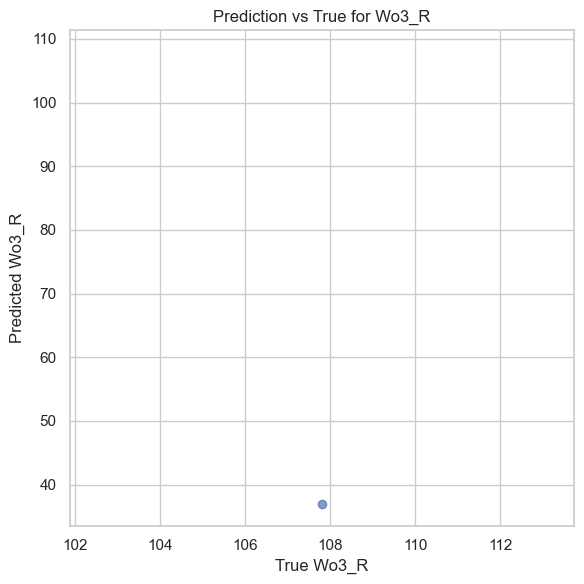

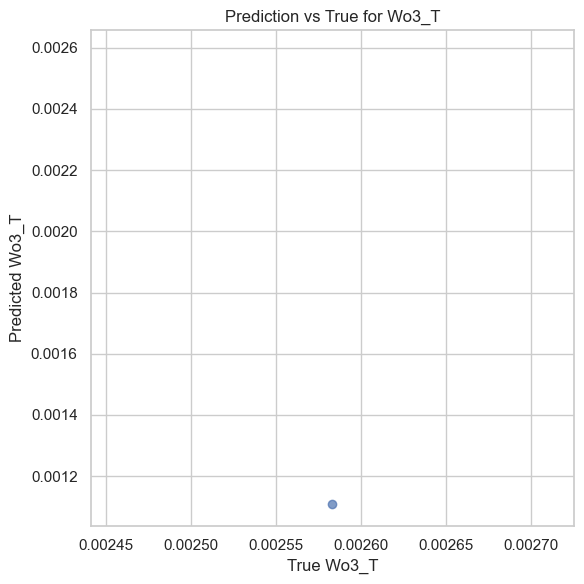

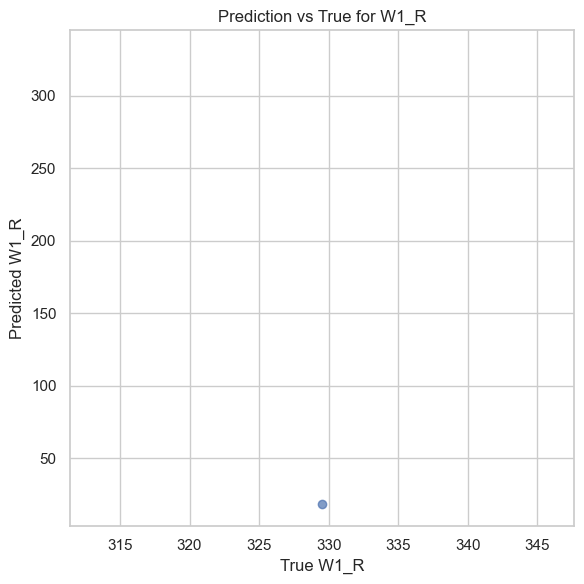

In [7]:
for i, name in enumerate(param_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.7)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--')
    plt.xlabel("True " + name)
    plt.ylabel("Predicted " + name)
    plt.title(f"Prediction vs True for {name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
joblib.dump(model, "rf_ecm_model.pkl")
joblib.dump(scaler, "eis_scaler.pkl")